# Relative Spatial Composites

Author: Clairy Reiher

Email: clairisse.reiher@colorado.edu

Last updated: April 16, 2025

This code provides a function that allows for composites to be constructed using data at different times within domains that are drawn relative to a series of central points, where each central point is valid at one of the times included in the composite. The code also demonstrates how this function can be used to construct a composited map of sea level pressure that is centered on the center of a mid-latitude cyclone, accounting for the fact that the position of the mid-latitude cyclone changes with time.

The **standard way that spatial compositing is performed** is by selecting data valid at several times across a region of interest, and then, at each grid point, averaging the values across the different times together. The resulting composited data is plotted over the same region of interest. In this case, data that contributes to the composite is selected from the same domain at each time.

<img src="./images/composite_reg.png" alt="drawing" width="900"/>

In this code, **spatial composites are constructed relative to a central point** that changes its location in time. Data that contributes to the composite is selected from a different domain at each time, where each domain is drawn relative to a given central point. The domains are then aligned and, at each grid point, an average weighted by the cosine of the latitude from each domain at that grid point is calculated. The resulting composited data is plotted over a grid with coordinates that are the average of the coordinates from all the domains.

<img src="./images/composite_rel.png" alt="drawing" width="900"/>

**How does this function work?**
The function takes as input:
- A 3D array of data with dimensions [time] x [latitude] x [longitude]
- A series of central points of dimension [time] specified by latitude and longitude
- The desired length along the sides of each domain and the final composite in latitude and longitude

Then the function iterates through each time in the data. At each time, the function does the following:
1. Retrieves the portion of the data within the domain bounds we've drawn around the central latitude and longitude valid at that time
2. Retrieves an array holding the cosine of the latitude at each grid point in the domain. These cosine values are required for the weighted average that yields the composite.

**Why do we use a weighted average?** The weighted average accounts for distortion of grid cell areas due to Earth's curvature. In a latitude/longitude grid, grid cells at higher latitudes have less area than grid cells at lower latitudes. To counteract this effect, the data at each grid point is weighted by the cosine of the grid point's latitude, which goes to 1 at the equator, and goes to 0 at the poles.


<img src="./images/lat_lon_grid.png" alt="drawing" width="400"/>


Image source: Kelly and Savric, 2020 (DOI: 10.1111/tgis.12636)

In [1]:
# Import modules
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator
from matplotlib import colormaps as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [2]:
def relative_composite(da, central_lats, central_lons, length_lat, length_lon):

    """
    Generate a spatial composite of a gridded variable relative to time-varying central latitude and 
    longitude points, with each time contributing a domain centered on those coordinates.

    Inputs
    ----------
    da : xarray.DataArray
        A 3D DataArray with dimensions ('time', 'latitude', 'longitude'), containing the variable 
        to composite. Must have `latitude` and `longitude` coordinates in degrees. 'valid_time' is
        accepted as an alternate name for the 'time' dimension.
    
    central_lats : array-like
        Latitude coordinate (one per time step) of central point of the domain at each time step. 
        Must be same length as the time dimension of `da`.

    central_lons : array-like
        Longitude coordinate (one per time step) of central point of the domain at each time step. 
        Must be same length as the time dimension of `da`.

    length_lat : float
        The length (in degrees) of the rectangular domain in the latitude direction to extract 
        around each central point. The extracted region extends `length_lat / 2` degrees north 
        and south from the central latitude.

    length_lon : float
        The length (in degrees) of the rectangular domain in the longitude direction to extract 
        around each central point. The extracted region extends `length_lon / 2` degrees north 
        and south from the central longitude.

    Outputs
    -------
    composite_da : xarray.DataArray
        A 2D DataArray containing the latitude-weighted composite. Dimensions are ('latitude', 
        'longitude').
    
    """
    
    # Check if input DataArray has the dimension "valid_time" instead of "time" (this is true
    # for output from the ERA5 Reanalysis) - if so, then rename the dimension to "time"
    if "valid_time" in da.dims:
        da = da.rename({"valid_time" : "time"})
    
    # Get the grid spacing of the data in the latitude and longitude directions
    lats_grid_1d = da.latitude
    lons_grid_1d = da.longitude
    deltalat = np.abs(lats_grid_1d[1] - lats_grid_1d[0])
    deltalon = np.abs(lons_grid_1d[1] - lons_grid_1d[0])

    # Get the nearest latitude and longitude to the central latitude and longitude
    # in the gridded data
    central_lats_grid = lats_grid_1d.sel(latitude  = central_lats,  method='nearest')
    central_lons_grid = lons_grid_1d.sel(longitude = central_lons,  method='nearest')

    # Get bounds for each domain drawn relative to the central latitudes and longitudes. 
    # This domain will identify the region at each time contributing to the composite
    domain_lats_N = central_lats_grid + (length_lat/2)
    domain_lats_S = central_lats_grid - (length_lat/2)
    domain_lons_W = central_lons_grid - (length_lon/2)
    domain_lons_E = central_lons_grid + (length_lon/2)

    # We'll need coordinates for plotting the final composite. To identify the bounds of these
    # coordinates, find the average latitude/longitude for each domain boundary
    domain_lat_avg_N = np.mean(domain_lats_N)
    domain_lat_avg_S = np.mean(domain_lats_S)
    domain_lon_avg_W = np.mean(domain_lons_W)
    domain_lon_avg_E = np.mean(domain_lons_E)

    # Correct for latitudes that surpass 89º. It's not practical to include latitudes 
    # above this bound, and we can't have latitudes surpassing 90.0 because they don't exist
    domain_lats_N = np.where(domain_lats_N > 89.0, 89, domain_lats_N)

    # Initialize a list to hold the domain grabbed at each time
    domains_list = []

    # Initialize array to hold the cosine of latitudes in each domain
    numtimes = int(len(da.time))
    numlats  = int(np.abs(domain_lats_N[0] - domain_lats_S[0])/deltalat) + 1
    numlons  = int(np.abs(domain_lons_W[0] - domain_lons_E[0])/deltalon) + 1
    coslats = np.zeros((numtimes, numlats, numlons))

    # Iterate through each time
    for i in range(0,len(da.time)):

        # Select the data within the domain we need at this time
        da_in_domain = da.isel(time = i)
        da_in_domain = da_in_domain.sel(latitude  = slice(domain_lats_N[i], domain_lats_S[i]), 
                                        longitude = slice(domain_lons_W[i], domain_lons_E[i]))

        # Convert to NumPy arrays
        da_vals = da_in_domain.values
        lats_in_domain = da_in_domain.latitude.values
        lons_in_domain = da_in_domain.longitude.values

        # Check if we had to cut the northen extent of the domain short to avoid including latitudes
        # above 89º. If we did do this, then we need to construct an array of NaNs that we'll append to the 
        # top of the selected data to fill out the remaining top portion of the domain with zeroes
        if len(da_in_domain.latitude) < numlats:
            num_to_add = numlats  - len(da_in_domain.latitude)
            false_grid_pts = np.zeros((num_to_add, len(da_in_domain.longitude)))
            da_vals = np.append(false_grid_pts,da_vals,axis=0)

            # Should add a latitude of 90 to represent these false grid points so that the cosine of these
            # latitudes contributes nothing to composite
            lats_in_domain = np.append(np.full(num_to_add, 90.0), lats_in_domain)

        # Save the data from the domain along with a 2D array of the cosine of the latitudes
        domains_list = domains_list + [da_vals]
        __, lats_in_domain_2d  = np.meshgrid(lons_in_domain,lats_in_domain)
        coslats[i,:,:] = np.cos(np.radians(lats_in_domain_2d)) 

    # Compute an average across the time dimension that is weighted by the cosine of the latitudes
    # from each domain
    domains = np.stack(domains_list,axis=0)
    domains_weighted = domains * coslats
    composite = np.sum(domains_weighted,axis=0)/np.sum(coslats,axis=0) 

    # Create arrays containing the latitude and longitude coordinates for the composite. Make sure the order of
    # the latitudes and longitudes matches that of the DataArray input to the relative_composite() function
    lats_composite = np.arange(domain_lat_avg_S, domain_lat_avg_N + deltalat, deltalat, dtype='float64')
    if lats_grid_1d[1] < lats_grid_1d[0]:
        lats_composite = lats_composite[::-1]
    lons_composite = np.arange(domain_lon_avg_W, domain_lon_avg_E + deltalon, deltalon, dtype='float64')
    if lons_grid_1d[1] < lons_grid_1d[0]:
        lons_composite = lons_composite[::-1]

    # Convert the composite to an Xarray DataArray object using the average coordinates calculated before
    composite_da = xr.DataArray(composite, dims = ('latitude','longitude'), 
                                name = 'composite_' + da.name, 
                                coords = {'latitude':lats_composite, 'longitude':lons_composite})

    return composite_da

To demonstrate how this function might be used, we will load in MSLP (mean sea level pressure) from the [ERA5 Reanalysis](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview), and a list of the latitudes and longitudes of points that roughly track the center of a mid-latitude cyclone in the data from ERA5. In this notebook, the "cyclone center" is defined by the location of the lowest MSLP value within the cyclone. I just estimated these points from maps of MSLP - they don't correspond to the exact minimum in MSLP, but they should be pretty close.

The mid-latitude cyclone focused on in this notebook was responsible for a deadly [tornado outbreak](https://en.wikipedia.org/wiki/Tornado_outbreak_of_March_13%E2%80%9316,_2025) over the Great Plains and Southeast United States on March 14 and 15, 2025. We'll use the compositing function to composite the MSLP distribution of this mid-latitude cyclone.

If you'd like to see a more real-world application of cyclone-centered composites, check out McKenzie Larson's research on Central U.S. mid-latitude cyclones.

In [3]:
# Load in the latitudes and longitudes of the center of the cyclone
path_pts = './data_relative_composites/cyclone_center_locations.txt'
df_pts = pd.read_csv(path_pts)
df_pts

,Time,Latitude,Longitude
0,2025-03-14 06:00,44.0,-102.0
1,2025-03-14 12:00,40.5,-101.5
2,2025-03-14 18:00,39.0,-101.0
3,2025-03-15 00:00,40.5,-97.5
4,2025-03-15 06:00,44.0,-95.0
5,2025-03-15 12:00,46.0,-94.0
6,2025-03-15 18:00,48.0,-90.0
7,2025-03-16 00:00,51.0,-85.0
8,2025-03-16 06:00,56.5,-82.5
9,2025-03-16 12:00,59.0,-83.5


In [4]:
# Load in MSLP from ERA5 
path_data = './data_relative_composites/era5_MSLP_20250313_20250316.nc'
file = xr.open_dataset(path_data)
mslp_all_times = file.msl

# Select only MSLP valid at the times from the file tracking the cyclone center
times_pts = pd.to_datetime(df_pts['Time'])
mslp = mslp_all_times.sel(valid_time = times_pts.values)

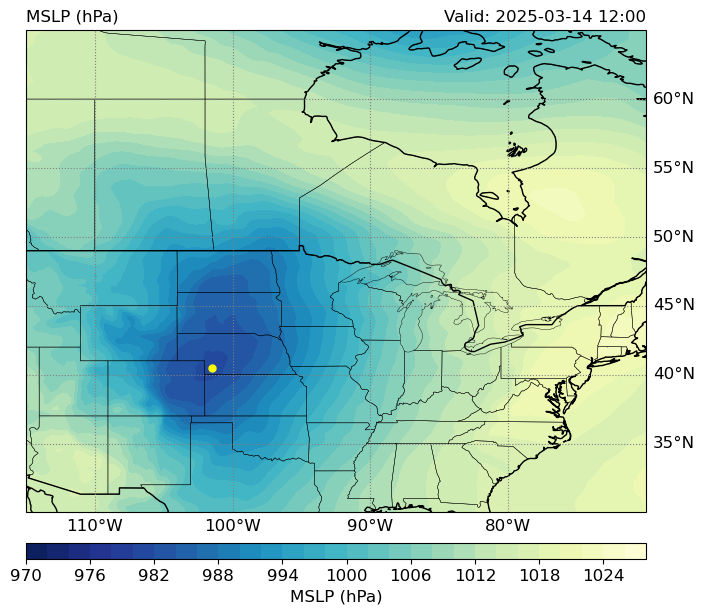

In [5]:
# Make a plot of MSLP at a sample time

# Enter in the time you'd like to plot
time_to_plot = '2025-03-14 12:00'

# Make sure the time above can be converted to a datetime object
try:
    dt_to_plot = np.datetime64(time_to_plot)
except ValueError:
    print("Wrong format used for time_to_plot.")
    raise

# Make sure there is MSLP at this time; if not, throw an error
if dt_to_plot not in mslp.valid_time:
    raise ValueError(f"'{time_to_plot}' not found in MSLP data.")

# Set up projections used for the map and the data
mapcrs  = ccrs.PlateCarree(central_longitude = -90)
datacrs = ccrs.PlateCarree()

# Set figure size
fig = plt.figure(figsize=(8,8))

# Create axes and set extent
ax = plt.axes(projection = mapcrs)
ax.set_extent([-115, -70, 30, 65], datacrs)

# Add geopolitical boundaries
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.3)

# Add gridlines and remove top + left labels
gridlines = ax.gridlines(color='gray',ls='dotted', draw_labels=True)
gridlines.top_labels  = False
gridlines.left_labels = False
gridlines.xlabel_style = {'size': 'large'}
gridlines.ylabel_style = {'size': 'large'}

# Plot shading of MSLP; convert from Pa to hPa
mslp_at_time = mslp.sel(valid_time = dt_to_plot)
cont_levels = np.arange(970,1030,2)
contf = ax.contourf(mslp_at_time.longitude, mslp_at_time.latitude, mslp_at_time/100, cont_levels, cmap=cm['YlGnBu_r'], transform=datacrs)

# Plot cyclone center
lat_cyclone_at_time = df_pts[times_pts == dt_to_plot]['Latitude'].values
lon_cyclone_at_time = df_pts[times_pts == dt_to_plot]['Longitude'].values
plt.scatter(lon_cyclone_at_time, lat_cyclone_at_time, s=25, c='yellow', transform=datacrs)

# Add colorbar for shading
cbar = plt.colorbar(contf, orientation='horizontal', pad=0.05, aspect=40)
cbar.set_label('MSLP (hPa)', size='large')
cbar.ax.tick_params(labelsize='large')

# Add title
plt.title('MSLP (hPa)',loc='left')
plt.title('Valid: '+time_to_plot, loc='right')

plt.show()

In [6]:
# Calculate the composite - specify a width of 30º in the latitude and longitude directions
lats_cyclone = df_pts['Latitude'].values
lons_cyclone = df_pts['Longitude'].values
mslp_comp = relative_composite(mslp, lats_cyclone, lons_cyclone, length_lat=30, length_lon=30)

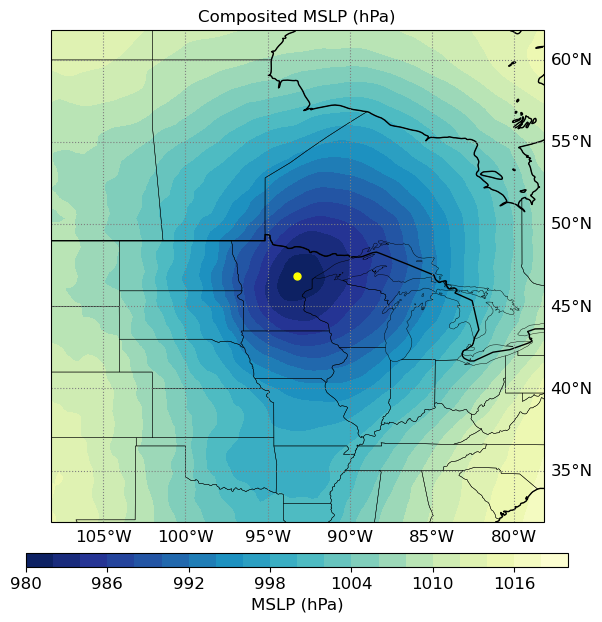

In [7]:
# Make a plot of the composited MSLP distribution of the cyclone

# Set up projections used for the map and the data
mapcrs  = ccrs.PlateCarree(central_longitude = -90)
datacrs = ccrs.PlateCarree()

# Set figure size
fig = plt.figure(figsize=(7,8))

# Create axes and set extent
ax = plt.axes(projection = mapcrs)
min_lon = mslp_comp.longitude.min()
min_lat = mslp_comp.latitude.min()
max_lon = mslp_comp.longitude.max()
max_lat = mslp_comp.latitude.max()
ax.set_extent([min_lon, max_lon, min_lat, max_lat], datacrs)

# Add geopolitical boundaries
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.3)

# Add gridlines and remove top + left labels
gridlines = ax.gridlines(color='gray',ls='dotted', draw_labels=True)
gridlines.top_labels  = False
gridlines.left_labels = False
gridlines.xlabel_style = {'size': 'large'}
gridlines.ylabel_style = {'size': 'large'}

# Force gridlines to only appear every 5 degrees latitude/longitude
gridlines.xlocator = MultipleLocator(5)
gridlines.ylocator = MultipleLocator(5)

# Plot shading of MSLP; convert from Pa to hPa
cont_levels = np.arange(980,1022,2)
contf = ax.contourf(mslp_comp.longitude, mslp_comp.latitude, mslp_comp/100, cont_levels, cmap=cm['YlGnBu_r'], transform=datacrs)

# Plot average cyclone center
lat_cyclone_mean = df_pts['Latitude'].mean()
lon_cyclone_mean = df_pts['Longitude'].mean()
plt.scatter(lon_cyclone_mean, lat_cyclone_mean, s=25, c='yellow', transform=datacrs)

# Add colorbar for shading
cbar = plt.colorbar(contf, orientation='horizontal', pad=0.05, aspect=40)
cbar.set_label('MSLP (hPa)', size='large')
cbar.ax.tick_params(labelsize='large')

# Add title
plt.title('Composited MSLP (hPa)',loc='center')

plt.show()